# Calculate Coulomb matrix and Gershgorin Circle Theorem descriptor for molecules in the QM9 dataset
In this tutorial, you will learn how to use the MolDes package to calculate various molecular descriptors. 
The codes in this tutorial are only suitable for calculating the descriptors of molecules in the QM9 dataset. If you wish to find a more generic code that is applicable to any molecule, please refer to T2. 

The dataset we used in this code and our paper [1] is the QM9 dataset [2], which contains organic molecules with up to nine heavy atoms. The heavy atoms are limited to carbon, nitrogen, oxygen, and fluorine. 

The QM9 dataset is publicly available, and could be downloaded from figshare: https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904

Before running this code, please download the xyz files from the link above.

[1] Mao, Yun-wen; Krems, Roman V. (2024). Eﬃcient interpolation of molecular properties across chemical compound space with low-dimensional descriptors. https://doi.org/10.1088/2632-2153/ad360e

[2] Ramakrishnan, Raghunathan; Dral, Pavlo; Rupp, Matthias; Anatole von Lilienfeld, O. (2014). Quantum chemistry structures and properties of 134 kilo molecules. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.978904.v5


In [88]:
from MolDes import GCT_util, CM_util # importing MolDes package

# import python libraries to run this code
import numpy as np
from rdkit import Chem

# import library for plots
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.image as image
from PIL import Image


In [89]:
import os

file_directory_path = os.getcwd()+"/"

#create CM of the molecule with minimum entropy
if "/Users/maoyunwen/Desktop/" in file_directory_path:
    qm9_xyz_dir = "/Users/maoyunwen/Desktop/0_delta_learning/0_GP_BO/QM9_dataset/"
elif "/Users/dawnmao/Desktop/" in file_directory_path:
    qm9_xyz_dir = "/Users/dawnmao/Desktop/0_GP_BO/qm9_dataset/dsgdb9nsd_xyz/"
elif  "/scratch/st-rkrems-1/ymaoai/" in file_directory_path:
    qm9_xyz_dir = "/scratch/st-rkrems-1/ymaoai/QM9_xyz_files/"

qm9_data_dir = file_directory_path + "data_files/"
qm9_auc_sim_dict = np.load("%sqm9_auc_n_similarity.npy"%(qm9_data_dir), allow_pickle='TRUE')[()]

First, we are going to create Coulomb matrix descriptor. The matrix element $M_ij$ in the coulomb matrix ($M$) is defined as 
\begin{equation}
  M_{ij} =
    \begin{cases}
      0.5Z_{i}^{2.4} & \text{for $i=j$}\\
      \frac{Z_i Z_j}{R_{ij}} & \text{for $i\neq j$} 
    \end{cases}\tag{1} 
\end{equation}

where $Z_i$ and $Z_j$ are the atomic numbers of atoms $i$ and $j$, respectively, and $R_{ij}$ is the separation between atoms $i$ and $j$. 

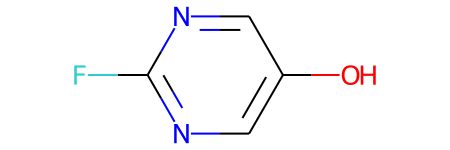

In [90]:
"""
In this first example, we are going to calculate the coulomb matrix of a molecule from the QM9 dataset
you could provide the SMILES string of the molecule, for example:
"""

ref_smi = "OC1=CN=C(F)N=C1"

# draw the molecule using the python package rdkit
mol = Chem.MolFromSmiles(ref_smi)
mol

In [91]:
# CM_arr: the coulomb matrix of "OC1=CN=C(F)N=C1"
# qm9_xyz_dir: the directory where the QM9 xyz files are
# ref_smi: SMILES string of the reference molecule
CM_arr = CM_util.create_CM_from_smi(qm9_xyz_dir, ref_smi)

print ("Coulomb matrix of %s:"%ref_smi)
print (CM_arr)


Coulomb matrix of OC1=CN=C(F)N=C1:
[[73.51669472 35.37462962 19.70260174 15.34731878 12.00136895 13.53212817
  15.54302193 20.2246184   8.30189106  2.92767956  3.05983697]
 [35.37462962 36.8581052  25.84284722 17.5871948  13.6174132  13.6192913
  17.60693526 25.78357646  3.13936624  2.77052686  2.78017131]
 [19.70260174 25.84284722 36.8581052  31.48833594 16.05237426 15.7078982
  15.44742515 15.20366707  2.412368    5.50557643  1.78215481]
 [15.34731878 17.5871948  31.48833594 53.3587074  31.84306889 28.16405495
  20.60498824 15.41870922  1.83599609  3.38479163  1.83709492]
 [12.00136895 13.6174132  16.05237426 31.84306889 36.8581052  40.8690681
  31.7738338  16.02959688  1.34988303  1.86039755  1.8566197 ]
 [13.53212817 13.6192913  15.7078982  28.16405495 40.8690681  97.53309975
  28.14784529 15.70455413  1.56555846  2.0921411   2.08886548]
 [15.54302193 17.60693526 15.44742515 20.60498824 31.7738338  28.14784529
  53.3587074  31.55572739  1.63033391  1.8381758   3.37544565]
 [20.2246

Each Gershgorin circle disc ($D_i$) of the coulomb matrix ($M$) is used to define a normal distribution function $f_i$
\begin{equation}
  f_i(x| \mu, \sigma^2) = \frac{1}{\sigma}\phi \left(\frac{x-\mu}{\sigma}\right),\tag{2} 
\end{equation}

where $\mu$ and $\sigma$ are the mean and the standard deviation of the normal distribution, and $\phi(\cdot)$ is the probability density function (PDF).

\begin{equation}
  f_{\rm molecule} = \sum_i^{n_{\rm max}} d_i \times f_i(x| \mu = M_{ii}, \sigma^2 = (\sum_{j\neq i} |M_{ij}|)^\tau).\tag{3} 
\end{equation}
where $d_i$ and $\tau$ are hyperparameters that allow adjustment on the weight on standard deviation of $f_i$, respectively. 


In [103]:
importlib.reload(GCT_util)
importlib.reload(CM_util)

x = np.linspace(-300, 300, 100)

# Define the variables for calculating the Gershgorin circle theorem descriptor
# x
# cum_pdf_norm_stat: 
# var_power: the \tau hyperparameter in eq. 3 (default = 1)
# di: the di hyperparameter in eq. 3 (default = 1)
GC_tau1 = GCT_util.GCT_util(x = x, cum_pdf_norm_stat = True, var_power = 1, di = 1)
GC_tau2 = GCT_util.GCT_util(x = x, cum_pdf_norm_stat = True, var_power = 2, di = 1)

# SMILES of the Reference molecule
ref_smi = "OC1=CN=C(F)N=C1"
# Calculated the 
ref_cum_pdf = GC_tau1.smi2cum_pdf_calc(qm9_xyz_dir, ref_smi)
ref_sq_cum_pdf = GC_tau2.smi2cum_pdf_calc(qm9_xyz_dir, ref_smi)
ref_AUC = GC.smi2auc_calc(qm9_xyz_dir, ref_smi)
print ("ref_smi:",ref_smi)
print ("AUC:", ref_AUC)
print ("Entropy x T= ", qm9_auc_sim_dict[ref_smi][-2]*298.15*630)
print ("ZPVE= ", qm9_auc_sim_dict[ref_smi][9]*630)

# SMILES of the C7H10O2 Isomer with the lowest Entropy
min_smi = "CC12OC3C1CC(O)C23"
min_cum_pdf = GC_tau1.smi2cum_pdf_calc(qm9_xyz_dir, min_smi)
min_sq_cum_pdf = GC_tau2.smi2cum_pdf_calc(qm9_xyz_dir, min_smi)
min_AUC = GC.smi2auc_calc(qm9_xyz_dir, min_smi)
print ("min_smi:",min_smi)
print ("AUC:", min_AUC)
print ("Entropy x T= ", qm9_auc_sim_dict[min_smi][-2]*298.15*630)
print ("ZPVE= ", qm9_auc_sim_dict[min_smi][9]*630)

# SMILES of the C7H10O2 Isomer with the highest Entropy
max_smi = "CC#CCC(=O)CCO"
max_cum_pdf = GC_tau1.smi2cum_pdf_calc(qm9_xyz_dir, max_smi)
max_sq_cum_pdf = GC_tau2.smi2cum_pdf_calc(qm9_xyz_dir, max_smi)
print ("min_smi:",max_smi)
print ("AUC:", max_AUC)
print ("Entropy x T= ", qm9_auc_sim_dict[max_smi][-2]*298.15*630)
print ("ZPVE= ", qm9_auc_sim_dict[max_smi][9]*630)


ref_smi: OC1=CN=C(F)N=C1
AUC: 0.15600530556127817
Entropy x T=  23.364809999990822
ZPVE=  46.15065
min_smi: CC12OC3C1CC(O)C23
AUC: 0.15735279446299708
Entropy x T=  25.644150000001673
ZPVE=  100.35647999999999
min_smi: CC#CCC(=O)CCO
AUC: 0.16105506380532134
Entropy x T=  33.69743999997411
ZPVE=  97.46289


Text(0, 0.5, 'Probability Density Function')

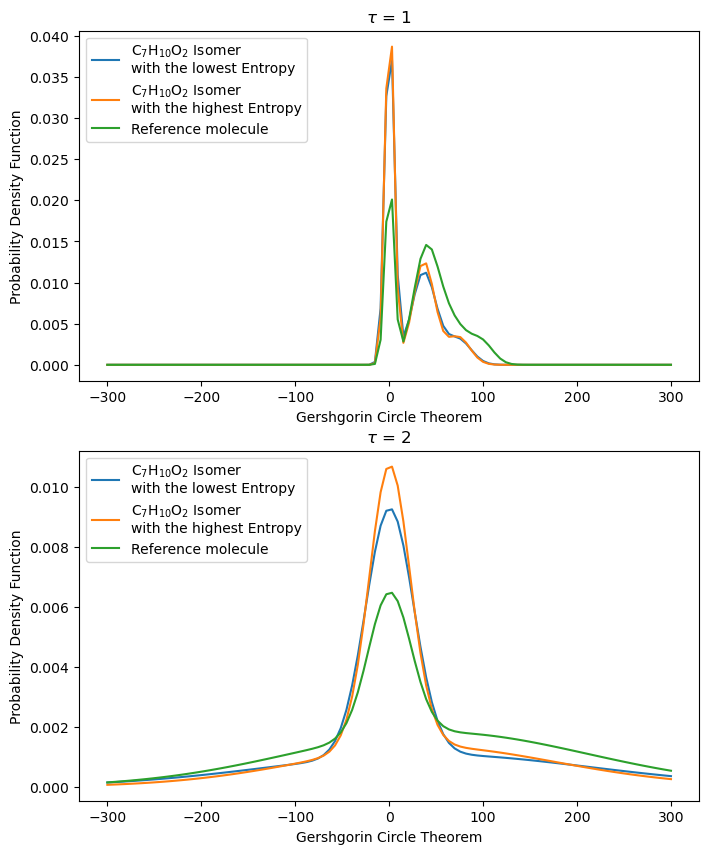

In [104]:
x_plot = np.linspace(-300, 300, 100)
fig, ax = plt.subplots(2,1,figsize=(8,10))
xlabel = "Gershgorin Circle Theorem"
ylabel = "Probability Density Function"
#print (sample_smi)
ax0 = ax[0]
ax0.plot(x_plot, min_cum_pdf, label = r"C$_7$H$_{10}$O$_2$ Isomer" + "\n" +"with the lowest Entropy")
ax0.plot(x_plot, max_cum_pdf, label = r"C$_7$H$_{10}$O$_2$ Isomer" + "\n" +"with the highest Entropy")
ax0.plot(x_plot, ref_cum_pdf, label = "Reference molecule")

ax0.legend(loc='upper left')
ax0.set_xlabel(xlabel)
ax0.set_ylabel(ylabel)
ax0.set_title(r"$\tau$ = 1")

ax1 = ax[1]
ax1.plot(x_plot, min_sq_cum_pdf, label = r"C$_7$H$_{10}$O$_2$ Isomer" + "\n" +"with the lowest Entropy")
ax1.plot(x_plot, max_sq_cum_pdf, label = r"C$_7$H$_{10}$O$_2$ Isomer" + "\n" +"with the highest Entropy")
ax1.plot(x_plot, ref_sq_cum_pdf, label = "Reference molecule")

ax1.set_title(r"$\tau$ = 2")
ax1.legend(loc='upper left')
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)

Instead of using the area under curve